In [33]:
import os
import json
import pandas as pd
import spacy
import numpy as np
from tqdm.notebook import tqdm
from spacy.tokens import DocBin
from spacy.vocab import Vocab
from spacy.scorer import Scorer
from spacy.training import Example
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
def load_and_run_model(base_path, file):
    # Load model components and test data
    nlp = spacy.load(base_path + file + '/model-best')
    textcat = nlp.get_pipe('textcat')
    doc_bin = DocBin().from_disk(base_path + file + '/test.spacy')
    docs = list(doc_bin.get_docs(nlp.vocab))
    scorer = Scorer(nlp)

    # Run inference
    examples = []
    for doc in docs:
        # Run pipeline
        prediction = nlp(doc.text)
        example = Example(prediction, doc)
        examples.append(example)
    
    # Assess performance from inference
    scores = scorer.score(examples)

    labels = textcat.label_data
    
    return examples, scores, labels


def calculate_false_label_proportion(examples):
    fp = 0
    total = len(examples)
    for example in examples:
        if example.reference.cats['No label'] and max(example.predicted.cats.items(), key=lambda it: it[1])[0] != 'No label':
            fp += 1
    return fp / total


def confusion_matrix_plot(examples, labels, file):
    ytrue = []
    ypred = []
    for example in examples:
        ytrue.append(max(example.reference.cats.items(), key=lambda it: it[1])[0])
        ypred.append(max(example.predicted.cats.items(), key=lambda it: it[1])[0])
    cf_matrix = metrics.confusion_matrix(ytrue, ypred, labels = labels)
    cf_matrix = pd.DataFrame(cf_matrix/(np.sum(cf_matrix, axis=1)[:, np.newaxis]), columns=labels)
    cf_matrix.index = labels
    plt.clf()
    sns.heatmap(cf_matrix, annot=True, fmt='.0%', cmap='turbo')
    plt.title(file)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'/training/echo/text_mining/output/textcat/cm_{file}.png', dpi=300)

  0%|          | 0/11 [00:00<?, ?it/s]

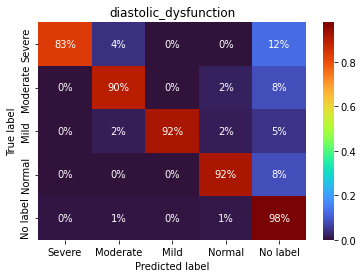

In [42]:
base_path = '/training/echo/text_mining/textcat_models/reduced_labels/spacy_data/'

df = pd.DataFrame(columns=['entity', 'cats_micro_p', 'cats_micro_r', 'cats_micro_f', 
                           'cats_macro_p', 'cats_macro_r', 'cats_macro_f', 'cats_macro_auc', 'fp', 'labels'])

files = [x for x in os.listdir(base_path) if not x.startswith('.') and x != 'merged_labels']

# Iterate over all abnormalities
for file in tqdm(files):
    data = {'entity': file}
    
    # Load model and data, run inference
    examples, scores, labels = load_and_run_model(base_path, file)
    
    # Assess PRF for all spans
    for metric in ['p', 'r', 'f']:
        # Table 3
        data[f'cats_micro_{metric}'] = scores[f'cats_micro_{metric}']
        data[f'cats_macro_{metric}'] = scores[f'cats_macro_{metric}']
        data['cats_macro_auc'] = scores['cats_macro_auc']

    # Calculate false label proportion (Table ?)
    data['fp'] = calculate_false_label_proportion(examples)

    data['labels'] = labels

    confusion_matrix_plot(examples, labels, file)
        
    # Add data row
    df.loc[len(df)] = data

In [40]:
df = df.sort_values('entity').reset_index(drop=True)
df

,entity,cats_micro_p,cats_micro_r,cats_micro_f,cats_macro_p,cats_macro_r,cats_macro_f,cats_macro_auc,fp,labels
0,aortic_regurgitation,0.956014,0.956014,0.956014,0.874595,0.856663,0.865059,0.988032,0.019749,"(Severe, Moderate, Mild, Normal, No label)"
1,aortic_stenosis,0.947368,0.947368,0.947368,0.862344,0.916878,0.884935,0.986363,0.029928,"(Severe, Moderate, Mild, Normal, No label)"
2,diastolic_dysfunction,0.956656,0.956656,0.956656,0.915832,0.908172,0.911697,0.993645,0.016512,"(Severe, Moderate, Mild, Normal, No label)"
3,lv_dil,0.952528,0.952528,0.952528,0.949042,0.925966,0.936399,0.987168,0.022704,"(Severe, Moderate, Mild, Normal, No label, Pre..."
4,lv_syst_func,0.951496,0.951496,0.951496,0.918482,0.916696,0.917185,0.980994,0.011352,"(Severe, Moderate, Mild, Normal, No label)"
5,mitral_regurgitation,0.952528,0.952528,0.952528,0.925634,0.912319,0.918448,0.984796,0.026832,"(Severe, Moderate, Mild, Normal, No label)"
6,pe,0.970400,0.970400,0.970400,0.697386,0.626910,0.641957,0.990809,0.006384,"(Severe, Moderate, Mild, Normal, No label, Pre..."
7,rv_dil,0.943408,0.943408,0.943408,0.927466,0.895804,0.908651,0.986364,0.025498,"(Severe, Moderate, Mild, Normal, No label, Pre..."
8,rv_syst_func,0.926729,0.926729,0.926729,0.879937,0.809148,0.836978,0.986547,0.034056,"(Severe, Moderate, Mild, Normal, No label)"
9,tricuspid_regurgitation,0.969040,0.969040,0.969040,0.964616,0.950989,0.957076,0.993628,0.017544,"(Severe, Moderate, Mild, Normal, No label)"


In [25]:
for metric in ['p', 'r', 'f']:
    df[f'{metric}'] = df.apply(lambda x: str(round(x[f'cats_micro_{metric}'], 2)) + ' (' + str(round(x[f'cats_macro_{metric}'], 2)) + ')', axis=1)
    
df['fp'] = df['fp'].apply(lambda x: round(x, 3))

In [26]:
## Table x - PRF scores micro/weighted (macro)
#df[['entity', 'f', 'r', 'p']].to_latex('/training/echo/text_mining/output/table4_textcat_pipeline_performance.tex', index=False)
df[['entity', 'f', 'r', 'p']]

,entity,f,r,p
0,aortic_regurgitation,0.96 (0.87),0.96 (0.86),0.96 (0.87)
1,aortic_stenosis,0.95 (0.88),0.95 (0.92),0.95 (0.86)
2,diastolic_dysfunction,0.96 (0.91),0.96 (0.91),0.96 (0.92)
3,lv_dil,0.95 (0.94),0.95 (0.93),0.95 (0.95)
4,lv_syst_func,0.95 (0.92),0.95 (0.92),0.95 (0.92)
5,mitral_regurgitation,0.95 (0.92),0.95 (0.91),0.95 (0.93)
6,pe,0.97 (0.64),0.97 (0.63),0.97 (0.7)
7,rv_dil,0.94 (0.91),0.94 (0.9),0.94 (0.93)
8,rv_syst_func,0.93 (0.84),0.93 (0.81),0.93 (0.88)
9,tricuspid_regurgitation,0.97 (0.96),0.97 (0.95),0.97 (0.96)


In [27]:
## Table x - False positives as a percentage per document
#df[['entity', 'fp']].to_latex('/training/echo/text_mining/output/tablex_textcat_false_positives.tex', index=False)
df[['entity', 'fp']]

,entity,fp
0,aortic_regurgitation,0.020
1,aortic_stenosis,0.030
2,diastolic_dysfunction,0.017
3,lv_dil,0.023
4,lv_syst_func,0.011
5,mitral_regurgitation,0.027
6,pe,0.006
7,rv_dil,0.025
8,rv_syst_func,0.034
9,tricuspid_regurgitation,0.018
